# Poisson equation

We will now investigate solutions to Poisson's equation:

$$
\nabla^2 V(\mathbf{r}) = \sum_i \frac{\partial^2 V}{\partial r_i^2} = -\alpha\rho(\mathbf{r})
$$

for potential $V$ and source density $\rho$. In the case of Coulomb's law, $\rho$ is the charge density and $V$ is the electric potential, with $\alpha = 1/\epsilon_0$.  


We will investigate both **relaxation** and **Fourier** solutions




## Relaxation solutions

As with BVPs, there are relaxation-based solutions in multiple dimensions for PDEs.  For simplicity we will consider Dirichlet boundary conditions such that the potential vanishes along the boundary 

$$V(\mathbf{r_\mathrm{boundary}}) = 0 $$

There are three methods we will investigate

- Jacobi iteration
$$
V_{i,j}^{n+1} = \frac{1}{4} \left( V_{i+1,j}^n + V_{i-1,j}^n + V_{i,j+1}^n + V_{i,j-1}^n + h^2 \rho_{i,j}\right)
$$

- Gauss-Seidel iteration (G-S)
$$
V_{i,j}^{n+1} = \frac{1}{4} \left( V_{i+1,j}^{n+1} + V_{i-1,j}^n + V_{i,j+1}^n + V_{i,j-1}^{n+1} + h^2 \rho_{i,j}\right)
$$

- Successive Over-Relaxation (SOR)
$$
V_{i,j}^{n+1} = (1-\omega)V_{i,j}^n + \frac{\omega}{4} \left( V_{i+1,j}^{n+1} + V_{i-1,j}^n + V_{i,j+1}^n + V_{i,j-1}^{n+1} + h^2 \rho_{i,j}\right)
$$

where $\omega$ is the "over-relaxation" parameter and can be tuned for performance. 

We will investigate the overall rates of convergence to a steady solution, as well as the overall computation time to a steady solution. We will see that the Jacobi solution has the worst performance per iteration, however, it can be vectorized, whereas the other two cannot! As such, despite it converging the slowest, it can achieve a target accuracy faster than the other two due to vectorization. (There is a caveat here, the G-S and SOR implementations are in pure `python`, so cleverer tricks could be done with `C++` loops, however I will not go over a `swig` solution here). 


In [1]:
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time

In [2]:
import numpy as np
import time
import cmath

class Poisson :
    def __init__ (self, L, rho_init, method, calcError = True):
        self.L = L                    # number of interior points in x and y
        self.omega = 1.88177          # over-relaxation parameter for L = 50
        self.N = L + 2                # interior plus two boundary points
        N=self.N
        self.V = np.zeros( (N, N) )   # potential to be found
        self.VNew = np.zeros( (N, N) )# new potential after each step
        self.h = 1.0 / (L + 1)        # lattice spacing assuming size in x and y = 1
        self.nsmooth = 3              # smoothing steps for multigrid method
        self.rho = np.array( rho_init )
        self.method=method        
        self.calcError = calcError
        self.error  = 0. if self.calcError else None
        self.errors = [] if self.calcError else None


    def __call__(self):
        return getattr(self,self.method)()

    def update(self):
        if self.calcError :
            self.error = np.sum( np.abs(self.V - self.VNew) ) / self.V.size
        self.V[:,:] = self.VNew[:,:]
        if self.calcError :
            self.errors.append(self.error)
            return self.error
        else :
            return None

        
    def Jacobi(self) :
        '''
        Jacobi algorithm for a single iterative step
        '''
        self.VNew = self.JacStep(self.VNew,self.V,self.h,self.rho)
        return self.update()

    def JacStep(self, u, v, h, rho):
        '''
        Jacobi algorithm on arbitrary inputs. Called once by "Jacobi".
        Called many times by "MultiGrid"
        '''
        u[1:-1,1:-1] = np.add.reduce([
            0.25*v[1:-1, 2:] ,
            0.25*v[1:-1, 0:-2],
            0.25*v[2:,   1:-1] ,
            0.25*v[0:-2, 1:-1] ,
            h**2 * rho[1:-1,1:-1]])
        return u

            
    def GaussSeidel(self):
        ''' 
        Gauss-Seidel algorithm for one iterative step
        '''
        self.VNew[:,:] = self.V[:,:]
        # perform Gauss-Seidel update
        for i in range(1, self.L+1):
            for j in range(1, self.L+1):
                self.VNew[i][j] = 0.25 * (self.VNew[i-1][j] + self.VNew[i+1][j] +
                                            self.VNew[i][j-1] + self.VNew[i][j+1] +
                                            self.h**2 * self.rho[i][j])
        return self.update()


    def SuccessiveOverRelaxation(self):
        '''
        Averages between G-S and J methods. 
        '''

        # update even sites in red-black scheme
        for i in range(1, self.L+1):
            for j in range(1, self.L+1):
                if (i + j) % 2 == 0:
                    self.VNew[i][j] = (1 - self.omega) * self.V[i][j] + self.omega / 4 * (
                                 self.V[i-1][j] + self.V[i+1][j] + self.V[i][j-1] +
                                 self.V[i][j+1] + self.h**2 * self.rho[i][j] )

        # update odd sites in red-black scheme
        for i in range(1, self.L+1):
            for j in range(1, self.L+1):
                if (i + j) % 2 != 0:
                    self.VNew[i][j] = (1 - self.omega) * self.V[i][j] + self.omega / 4 * (
                                 self.VNew[i-1][j] + self.VNew[i+1][j] + self.VNew[i][j-1] +
                                 self.VNew[i][j+1] + self.h**2 * self.rho[i][j] )
        return self.update()


    def FFT(self):
        '''
        Explicitly solves differential equation in Fourier domain
        '''
        
        # Make a grid to get indices
        x = np.arange(self.N)
        y = np.arange(self.N)
        xx,yy = np.meshgrid(x,y)
        # Construct root of unity
        i = 0. + 1.j
        W = cmath.exp( 2 * i * cmath.pi / float(self.N) )
        # Get the denominator using the grid
        d = 4.0 - np.power(W, xx ) - np.power(W, -xx) - np.power(W, yy) - np.power(W, -yy)
        valid_d = (d > 0.0)
        # FFT of rho columns
        rhof = np.fft.fft(self.rho, axis=0)
        # FFT of rho rows
        rhof = np.fft.fft(rhof,axis=1)
        # Solve for V in Fourier domain
        Vf = np.divide( rhof * self.h**2, d, out=np.zeros_like(d, dtype=complex), where=np.absolute(d)>0)
        # IFFT of V rows
        self.V = np.fft.ifft( Vf, axis=0)
        # IFFT of V columns
        self.V = np.fft.ifft( self.V, axis=1)
        return 



For the relaxation simulations, we will put a point charge in the center of a "grounded box" (Dirichlet boundary conditions) and allow the solution to converge. We will first plot the wavefunction as determined by the Jacobi method (the others look almost identical). 

In [3]:
L = 14
N = L+2
q = 10.0                # point charge
i = N // 2                    # center of lattice
h = 1/(L+1)
rho = np.zeros( (N,N))
rho[i,i] = q / h**2    # charge density

nsteps = 100
steps = np.arange(nsteps)
p = Poisson(L,rho, 'Jacobi')
for i in steps : 
    p()


Text(0.5, 0.5, 'y')

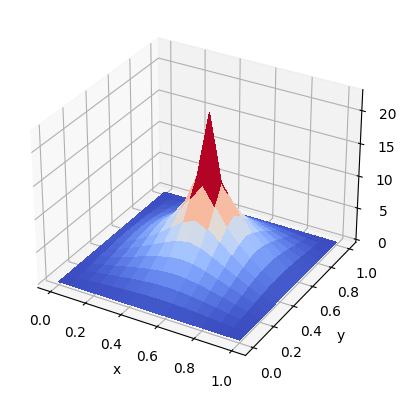

In [4]:

# Define the axes
x = np.arange(0, p.h*(p.L+2), p.h)
y = np.arange(0, p.h*(p.L+2), p.h)
# Get the grid
X, Y = np.meshgrid(x, y)
# Set Z to the poisson V[i][j]
Z = np.array( p.V )

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sur = ax.plot_surface( X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False )
plt.xlabel("x")
plt.ylabel("y")

### Convergence versus iteration

Here we will compute the convergence (the difference between successive evaluations of the potential) as a function of the number of iterations. 

We see that Jacobi performs worst, G-S is second, and SOR is the best. 

In [5]:
methods = ["Jacobi", "GaussSeidel", "SuccessiveOverRelaxation"]
solvers = []
times = np.zeros( len(methods))
for i,method in enumerate(methods) : 
    p = Poisson(L,rho, method)
    err = []
    t1 = time.perf_counter()    
    for j in steps : 
        ierr = p()
    t2 = time.perf_counter()
    solvers.append(p)
    times[i] = (t2-t1)
    print("Method %40s processed %d steps in %6.5f  s" % (method, len(steps), times[i]) )

Method                                   Jacobi processed 100 steps in 0.00785  s
Method                              GaussSeidel processed 100 steps in 0.03615  s
Method                 SuccessiveOverRelaxation processed 100 steps in 0.04328  s


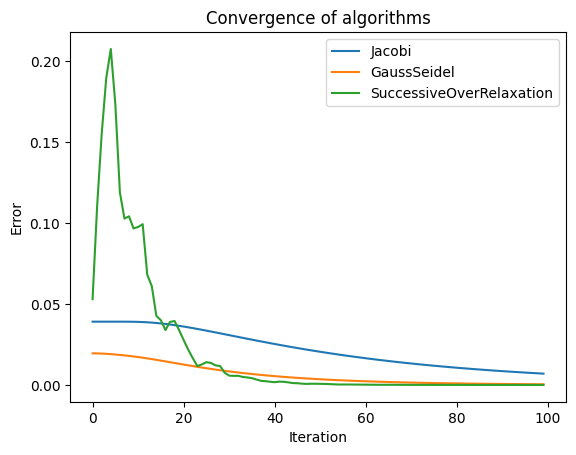

In [6]:
fig = plt.figure(2)
for i,method in enumerate(methods) :     
    plt.plot(steps, solvers[i].errors, label=method )
plt.title("Convergence of algorithms")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.legend()
plt.show()

### Performance in time

We now investigate how quickly it takes each algorithm to reach a given precision (in this case, one part per million). Due to the vectorization of the Jacobi algorithm, it is able to acheive the target precision faster than both G-S and SOR, despite requiring more iterations. 

In [7]:
solvers = []
acc = 1e-6
times = np.zeros( len(methods))
for i,method in enumerate(methods) : 
    p = Poisson(L,rho, method)
    err = []
    ierr = 9999.
    t1 = time.perf_counter()
    while ierr > acc :    
        ierr = p()
    t2 = time.perf_counter()
    solvers.append(p)
    times[i] = (t2-t1)
    print("Accuracy %6.2e reached in %6.5f  s" % (acc, times[i]) )

Accuracy 1.00e-06 reached in 0.02128  s
Accuracy 1.00e-06 reached in 0.07718  s
Accuracy 1.00e-06 reached in 0.04152  s


### Take-home message

The message here is that there is now truly a trade-off between complex algorithms with deep loops, and simple algorithms that can be easily vectorized. Depending on the application, one or another approach may be favored. You should be aware of this fact as you go forward in your career path!

***
***
***

## FFT Solution


Similarly to your courses, you can also numerically solve PDEs in the frequency domain instead of the time domain using Fourier analysis. In this case, we can also look at FFTs. For simplicity we will impose boundary conditions such that the limit of the potential tends to zero at infinite radius. 

Since the FFT is a linear operation, we can perform the FFT and inverse FFT separately for the rows and columns of the 2d distribution. The Fourier components are

$$
\tilde{V}_{mn} = \frac{h^2 \tilde{\rho}_{mn}}{4 - W^m - W^{-m} - W^n - W^{-n}}
$$

where $W = \exp(2i\pi/N)$ is a root of unity. 

In the end, it is often much faster to compute FFT-based solutions, especially for large values of $N$. In an apples-to-apples comparison, the fastest relaxation technique takes around 300 times longer for N=14 interior points (N=16 total points). 

In [8]:
L = 14
N = L+2
q = 10.0                # point charge
h = 1/(L+1)
rho = np.zeros( (N,N))
rho[N // 2,N // 2] = q / h**2    # charge density

p = Poisson(L,rho, method="FFT")
t1 = time.perf_counter()
p()
t2 = time.perf_counter()

print("Solution computation took %6.5f s"% (t2-t1))

Solution computation took 0.00173 s


Text(0.5, 0.5, 'y')

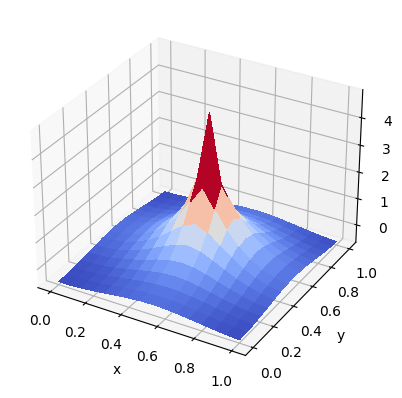

In [10]:

# Define the axes
x = np.arange(0, p.h*(p.L+2), p.h)
y = np.arange(0, p.h*(p.L+2), p.h)
# Get the grid
X, Y = np.meshgrid(x, y)
# Set Z to the poisson V[i][j]
Z = np.array( p.V.real )

fig = plt.figure(1)
ax = fig.add_subplot(projection='3d')
sur = ax.plot_surface( X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False )
plt.xlabel("x")
plt.ylabel("y")